In [11]:
import pickle
import numpy as np

with open('data/SMRT/coefficients.pkl', 'rb') as file:
    preds = pickle.load(file)
    np_preds = {}
    for name in preds:
        np_preds[name] = preds[name].detach().cpu().numpy()
    preds = np_preds
    np.save('data/SMRT/coefficients.npy', preds)

with open('data/SMRT/adjacencies.pkl', 'rb') as file:
    adj = pickle.load(file)
    np.save('data/SMRT/adjacencies.npy', adj)

with open('data/SMRT/distances.pkl', 'rb') as file:
    dist = pickle.load(file)
    np.save('data/SMRT/distances.npy', dist)

In [16]:
loaded_data = np.load('data/SMRT/distances.npy', allow_pickle=True)
loaded_data.item()

{'53165246': array([[0., 1., 2., ..., 6., 4., 4.],
        [1., 0., 1., ..., 5., 3., 3.],
        [2., 1., 0., ..., 6., 4., 4.],
        ...,
        [6., 5., 6., ..., 0., 4., 4.],
        [4., 3., 4., ..., 4., 0., 2.],
        [4., 3., 4., ..., 4., 2., 0.]], shape=(53, 53)),
 '292850': array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  6.,  7.,  8.,  9., 10.,  9.,
          8.,  5.,  4.,  3.,  1.,  1.,  1.,  4.,  5.,  7.,  9., 10., 11.,
         10.,  9.,  6.,  4.],
        [ 1.,  0.,  1.,  2.,  3.,  4.,  5.,  5.,  6.,  7.,  8.,  9.,  8.,
          7.,  4.,  3.,  2.,  2.,  2.,  2.,  3.,  4.,  6.,  8.,  9., 10.,
          9.,  8.,  5.,  3.],
        [ 2.,  1.,  0.,  1.,  2.,  3.,  4.,  4.,  5.,  6.,  7.,  8.,  7.,
          6.,  3.,  2.,  1.,  3.,  3.,  3.,  2.,  3.,  5.,  7.,  8.,  9.,
          8.,  7.,  4.,  2.],
        [ 3.,  2.,  1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  7.,
          6.,  4.,  3.,  2.,  4.,  4.,  4.,  1.,  2.,  4.,  7.,  8.,  9.,
          8.,  7.,  5.,  3.],
 

In [133]:
import csv

smiles = {}
retention_time = {}
with open('data/SMRT/SMART_dataset_enn_short.csv') as file:
    reader = csv.reader(file, delimiter=';')
    for line in reader:
        smiles[line[0]] = line[1]
        retention_time[line[0]] = float(line[2])

In [134]:
key = '53165246'
print(preds[key])
print(adj[key])
print(dist[key])
print(retention_time[key])
print(smiles[key])

tensor([[ 0.0340, -0.0058,  0.0774,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0180,  0.0202,  0.1215,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0312, -0.0435,  0.1107,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0012,  0.1011,  0.4531,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0165,  0.1005,  0.4765,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0041,  0.1086,  0.4952,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')
[[0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0. 1. 2. ... 6. 4. 4.]
 [1. 0. 1. ... 5. 3. 3.]
 [2. 1. 0. ... 6. 4. 4.]
 ...
 [6. 5. 6. ... 0. 4. 4.]
 [4. 3. 4. ... 4. 0. 2.]
 [4. 3. 4. ... 4. 2. 0.]]
780.8
O=S(=O)(c1ccc2c(c1)CCCC2)N1CCCn2nc(-c3cccnc3)cc2C1


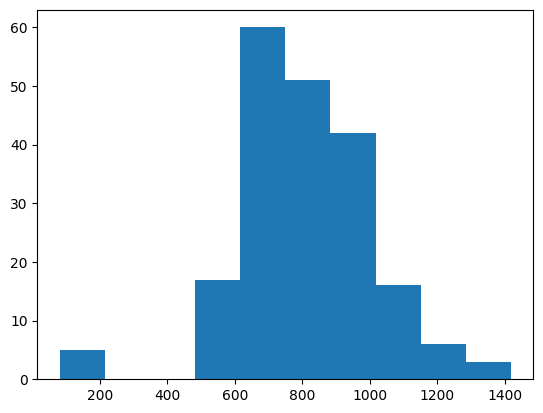

In [135]:
from matplotlib import pyplot as plt

plt.hist(list(retention_time.values()))
plt.show()

In [136]:
from rdkit import Chem
from rdkit.Chem import AllChem

mols = {}
fps = {}

fpgen = AllChem.GetRDKitFPGenerator()

for key in smiles:
    mol = Chem.MolFromSmiles(smiles[key])
    mols[key] = mol
    fps[key] = fpgen.GetFingerprint(mol)

In [137]:
# lets get pairwise

from rdkit import DataStructs

retention_diff = {}
tanimoto_sim = {}

keys = list(preds.keys())
sim_pairs = []

for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        sim_pairs.append((keys[i], keys[j]))

for key in sim_pairs:
    retention_diff[key] = abs(retention_time[key[0]] - retention_time[key[1]])
    tanimoto_sim[key] = DataStructs.TanimotoSimilarity(fps[key[0]], fps[key[1]])

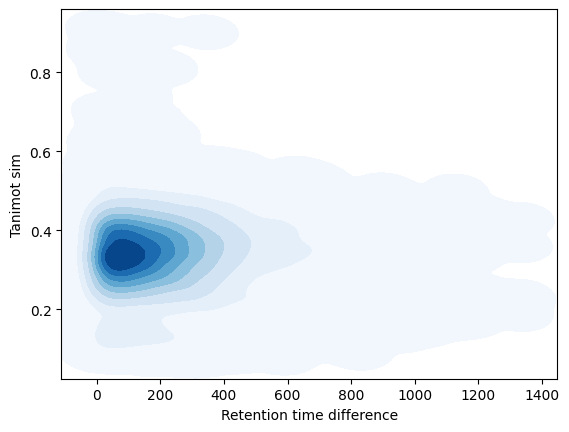

In [138]:
import seaborn as sns

x = []
y = []
for key in sim_pairs:
    x.append(retention_diff[key])
    y.append(tanimoto_sim[key])

sns.kdeplot(x=x, y=y, fill=True, cmap="Blues", thresh=0.00001)
plt.ylabel('Tanimot sim')
plt.xlabel('Retention time difference')
plt.show()

In [139]:
import ot
from tqdm import tqdm
import numpy as np

def calculate_gw_distance(node_features_1, distance_1, node_features_2, distance_2):
    
    # Define Distributions
    # We assume uniform distribution (each point has equal weight)
    p = ot.unif(node_features_1.shape[0])
    q = ot.unif(node_features_2.shape[0])

    # Calculate the Feature Distance Matrix (M)
    # M[i, j] is the distance between feature vector of node i in G1 and node j in G2
    # metric='euclidean' is standard, but you can use 'sqeuclidean', 'cosine', etc.
    M = ot.dist(node_features_1, node_features_2, metric='euclidean')

    # The alpha parameter controls the trade-off:
    # alpha = 0: Pure Gromov-Wasserstein (Structure only)
    # alpha = 1: Pure Wasserstein (Features only)
    # 0 < alpha < 1: Fused (Both)
    alpha = 0.25
    
    # fused_gromov_wasserstein2 returns the actual distance value (scalar)
    gw_dist = ot.gromov.fused_gromov_wasserstein2(
        M,
        distance_1, 
        distance_2, 
        p, 
        q, 
        loss_fun='square_loss',
        alpha=alpha,
        verbose=False,
    )
    
    return gw_dist


gw_dist = {}

for key in tqdm(sim_pairs):
    gw_dist[key] = calculate_gw_distance(preds[key[0]].detach().cpu().numpy(), dist[key[0]], preds[key[1]].detach().cpu().numpy(), dist[key[1]])

gw_dist

100%|██████████| 18528/18528 [00:46<00:00, 398.77it/s]


{('53165246', '292850'): np.float64(2.022919806881842),
 ('53165246', '53074813'): np.float64(1.587785361911477),
 ('53165246', '53133218'): np.float64(1.491236234422609),
 ('53165246', '53018843'): np.float64(1.3747850919898879),
 ('53165246', '87051331'): np.float64(2.2776942551241888),
 ('53165246', '53175209'): np.float64(1.3765836205584798),
 ('53165246', '46394732'): np.float64(1.4568982945068332),
 ('53165246', '53141103'): np.float64(1.459962002202451),
 ('53165246', '18575643'): np.float64(1.2067644110809854),
 ('53165246', '53012019'): np.float64(1.335024032680878),
 ('53165246', '83282947'): np.float64(1.1509740430566888),
 ('53165246', '49666968'): np.float64(0.9951485680376767),
 ('53165246', '71837919'): np.float64(1.814050427147172),
 ('53165246', '49665985'): np.float64(1.1589837000093908),
 ('53165246', '53133954'): np.float64(2.290743734570486),
 ('53165246', '124045368'): np.float64(1.1356572052446914),
 ('53165246', '50836000'): np.float64(1.3977042634707335),
 ('53

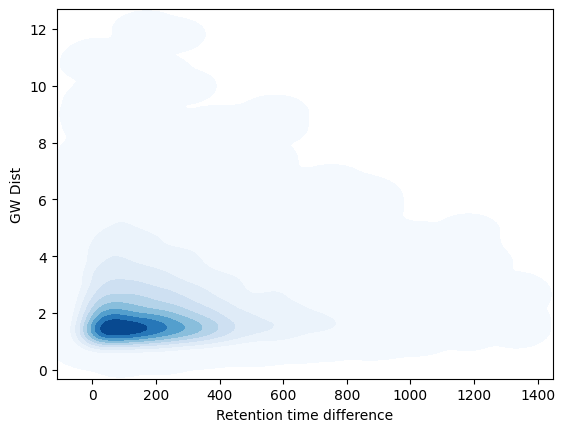

In [140]:
x = []
y = []
for key in sim_pairs:
    x.append(retention_diff[key])
    y.append(gw_dist[key])

sns.kdeplot(x=x, y=y, fill=True, cmap="Blues", thresh=0.00001)
plt.ylabel('GW Dist')
plt.xlabel('Retention time difference')
plt.show()

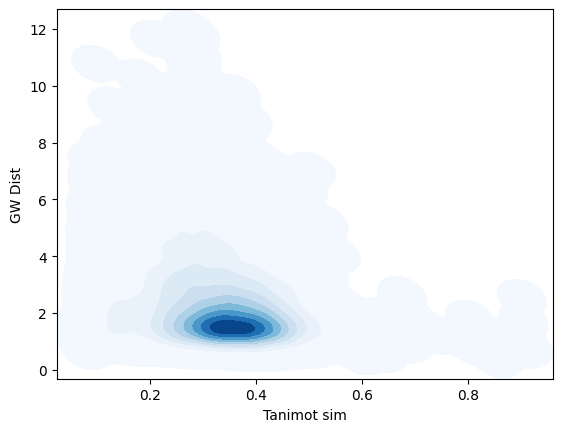

In [141]:
x = []
y = []
for key in sim_pairs:
    x.append(tanimoto_sim[key])
    y.append(gw_dist[key])

sns.kdeplot(x=x, y=y, fill=True, cmap="Blues", thresh=0.00001)
plt.ylabel('GW Dist')
plt.xlabel('Tanimot sim')
plt.show()

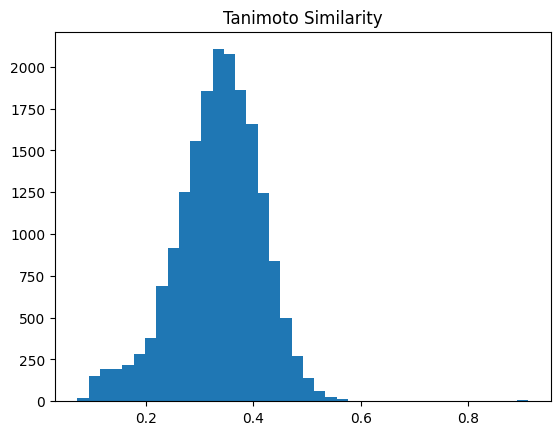

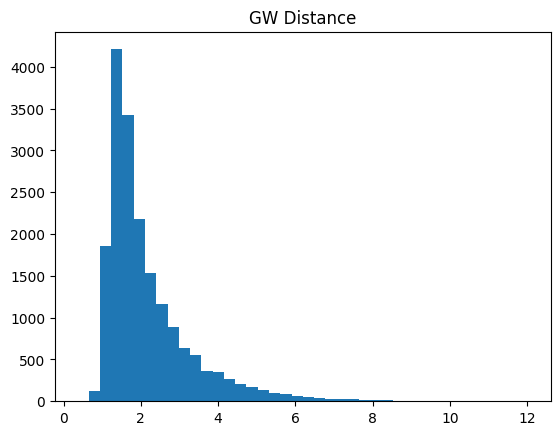

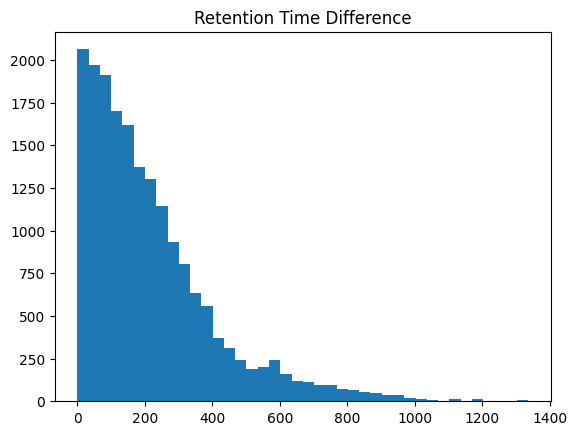

In [142]:
x = []
y = []
z = []
for key in sim_pairs:
    x.append(tanimoto_sim[key])
    y.append(gw_dist[key])
    z.append(retention_diff[key])


plt.hist(x, bins=40)
plt.title('Tanimoto Similarity')
plt.show()
plt.hist(y, bins=40)
plt.title('GW Distance')
plt.show()
plt.hist(z, bins=40)
plt.title('Retention Time Difference')
plt.show()

In [12]:
with open('data/welQrate/AID435034/coefficients.pkl', 'rb') as file:
    preds = pickle.load(file)
    np_preds = {}
    for name in preds:
        np_preds[name] = preds[name].detach().cpu().numpy()
    preds = np_preds
    np.save('data/welQrate/AID435034/coefficients.npy', preds)

with open('data/welQrate/AID435034/distances.pkl', 'rb') as file:
    dist = pickle.load(file)
    np.save('data/welQrate/AID435034/distances.npy', dist)

with open('data/welQrate/AID435034/adjacencies.pkl', 'rb') as file:
    adj = pickle.load(file)
    np.save('data/welQrate/AID435034/adjacencies.npy', adj)

active_keys = []
inactive_keys = []
with open('data/welQrate/AID435034/AID435034_enn.csv') as file:
    for line in file:
        line = line.strip().split(';')
        if line[0] in preds:
            if line[2] == 'active':
                active_keys.append(line[0])
            elif line[2] == 'inactive':
                inactive_keys.append(line[0])

print(len(preds), len(active_keys), len(inactive_keys))

264 75 189


In [144]:
a_a_gw = []
i_i_gw = []
a_i_gw = []

for i in tqdm(range(len(active_keys))):
    for j in range(i+1, len(active_keys)):
        key1 = active_keys[i]
        key2 = active_keys[j]
        a_a_gw.append(calculate_gw_distance(preds[key1].detach().cpu().numpy(), dist[key1], preds[key2].detach().cpu().numpy(), dist[key2]))

for i in tqdm(range(len(inactive_keys))):
    for j in range(i+1, len(inactive_keys)):
        key1 = inactive_keys[i]
        key2 = inactive_keys[j]
        i_i_gw.append(calculate_gw_distance(preds[key1].detach().cpu().numpy(), dist[key1], preds[key2].detach().cpu().numpy(), dist[key2]))

for i in tqdm(range(len(inactive_keys))):
    for j in range(len(active_keys)):
        key1 = inactive_keys[i]
        key2 = active_keys[j]
        a_i_gw.append(calculate_gw_distance(preds[key1].detach().cpu().numpy(), dist[key1], preds[key2].detach().cpu().numpy(), dist[key2]))

100%|██████████| 189/189 [00:35<00:00,  5.33it/s]


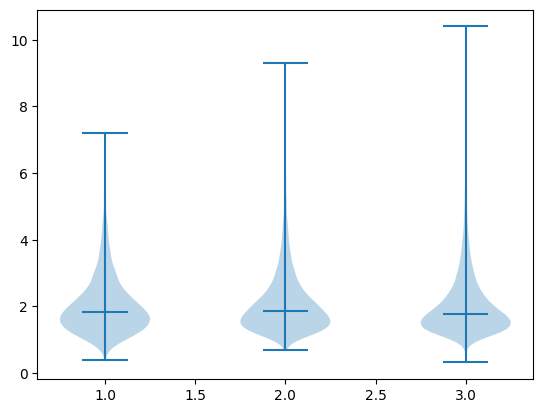

In [145]:
plt.violinplot([a_a_gw, a_i_gw, i_i_gw], showextrema=True, showmedians=True)
plt.show()

In [149]:
tani_gw_agreements = []
tani_gw_disagreements = []

for key in sim_pairs:
    if tanimoto_sim[key] > 0.8 and gw_dist[key] < 2:
        tani_gw_agreements.append(key)
    if tanimoto_sim[key] < 0.2 and gw_dist[key] < 1:
        tani_gw_disagreements.append(key)

print(len(tani_gw_agreements))
print(len(tani_gw_disagreements))

13
10


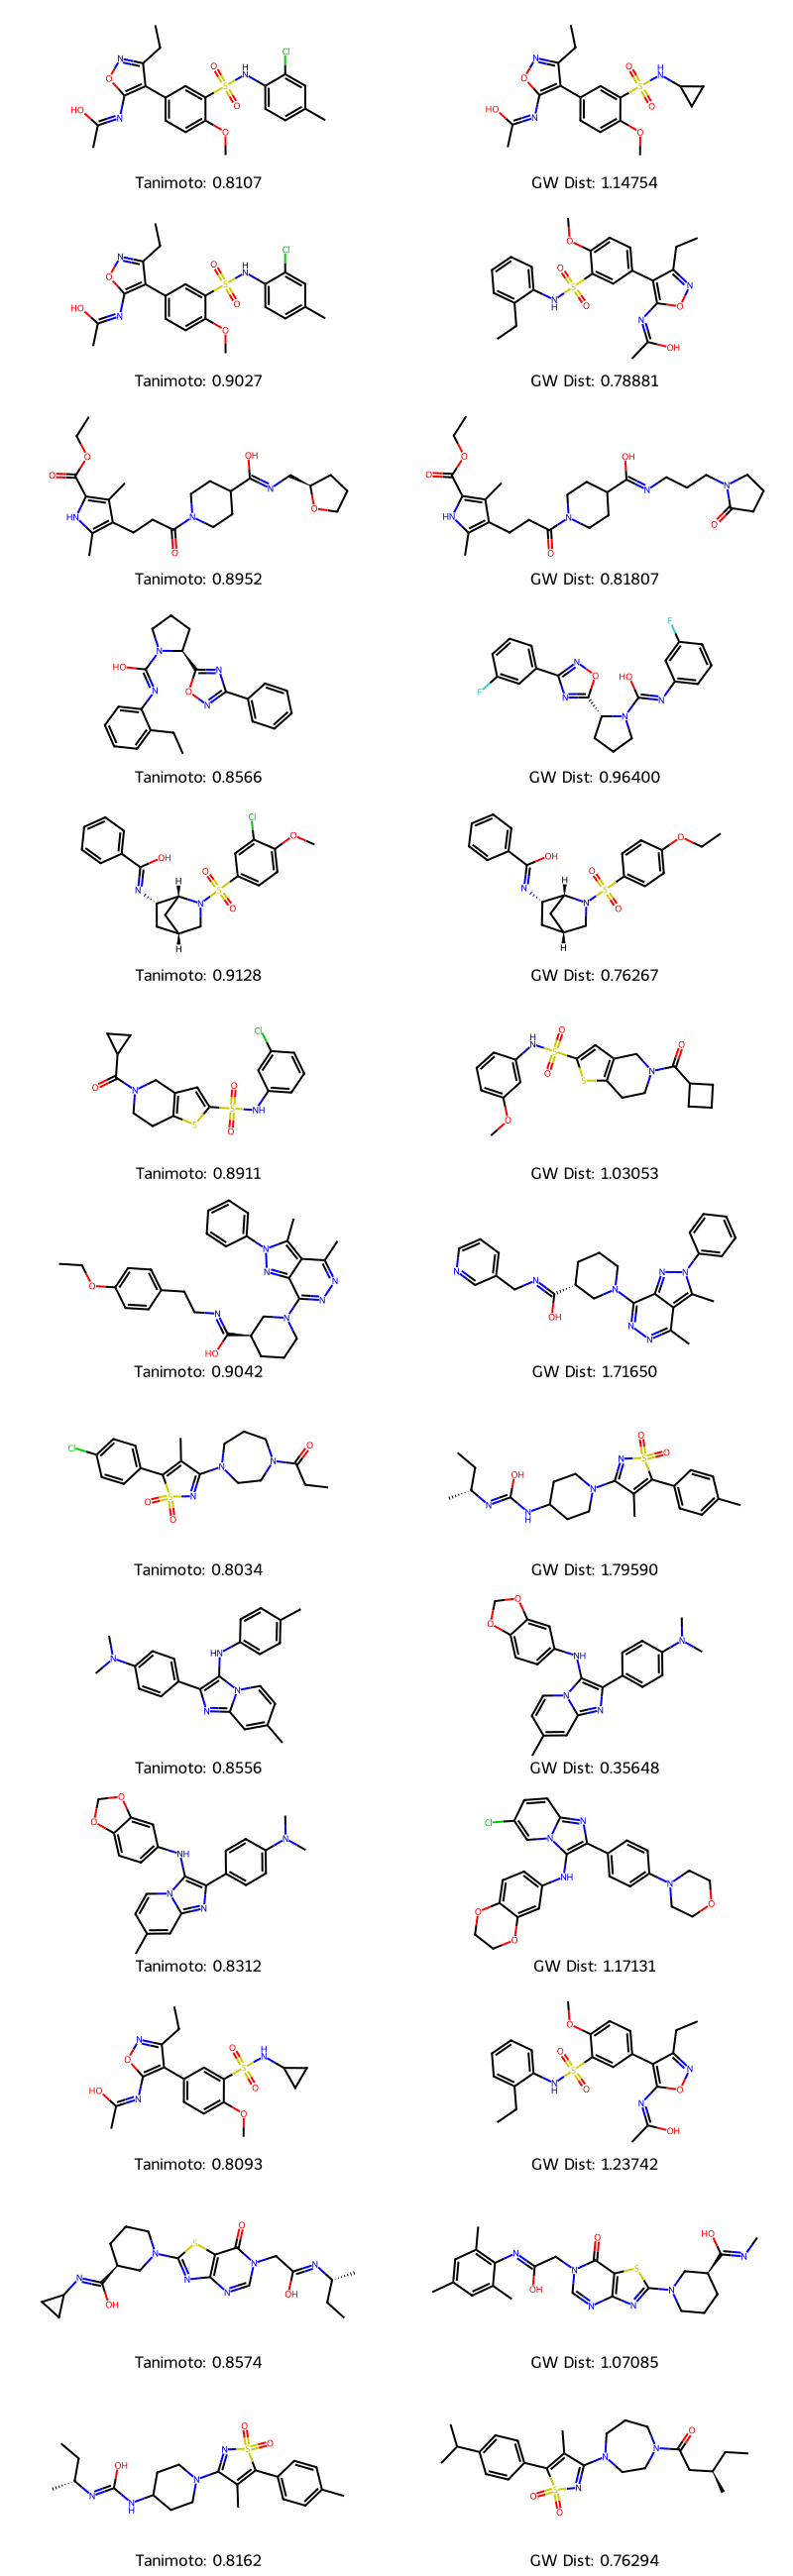

In [150]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

draw = []
leg = []
for key in tani_gw_agreements:
    draw.append(mols[key[0]])
    draw.append(mols[key[1]])
    leg.append("Tanimoto: " + f"{tanimoto_sim[key]:.4f}")
    leg.append("GW Dist: " + f"{gw_dist[key]:.5f}")
Draw.MolsToGridImage(draw, molsPerRow=2, subImgSize=(400,200), legends=leg)


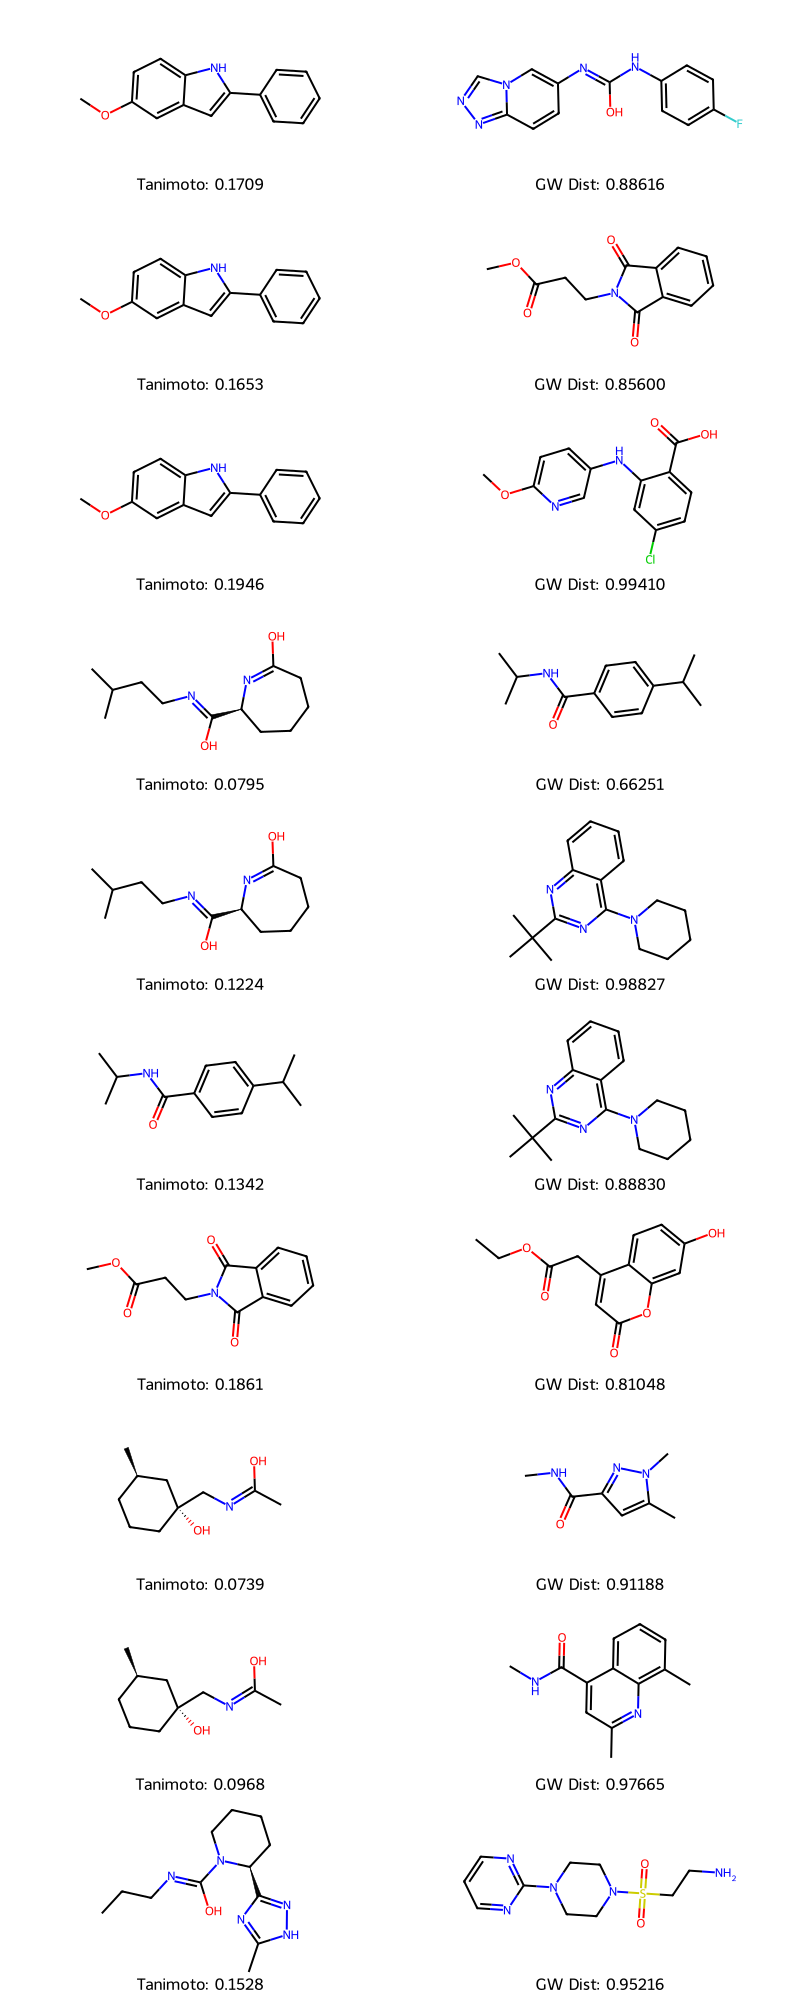

In [151]:
draw = []
leg = []
for key in tani_gw_disagreements:
    draw.append(mols[key[0]])
    draw.append(mols[key[1]])
    leg.append("Tanimoto: " + f"{tanimoto_sim[key]:.4f}")
    leg.append("GW Dist: " + f"{gw_dist[key]:.5f}")
Draw.MolsToGridImage(draw, molsPerRow=2, subImgSize=(400,200), legends=leg)

In [152]:
with open('/home/iwe20/Projects/ElektroNN/elektronn/models/basisfunction_params.pkl', 'rb') as file:
    basis = pickle.load(file)

basis[1]

{'exp': tensor([15.6753,  3.6064,  1.2080,  0.4727,  0.2018,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  2.0281,  2.0281,
          2.0281,  0.5359,  0.5359,  0.5359,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          2.2165,  2.2165,  2.2165,  2.2165,  2.2165,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.

In [153]:
basis.keys()

dict_keys([1.0, 6.0, 7.0, 8.0, 9.0, 16.0, 17.0])